# Triage Agent

Gather a high-level overview of the cluster's health and identify potential problem areas.

## Deterministic data gathering

- **Pod Status Check**:
    - `Tool`: `K8sAPI.get_problematic_pods()`
    - `Output`: Pods with pending states, container errors, high restarts (>3)
- **Trace Analysis**:
    - `Tool`: `JaegerAPI.get_processed_traces()` and `JaegerAPI.get_slow_traces()`
    - `Output`: Traces with errors or high latency, including service sequences
- **Metrics Analysis**:
    - `Tool`: `PrometheusAPI.get_pod_triage_metrics()`
    - `Output`: Pods with thread saturation (>95%), high CPU load (>10.0), or network errors

In [1]:
from dotenv import load_dotenv
import os
# Get the path to the root directory of the repository
root_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))

# Load environment variables from .env file in the root directory
load_dotenv(os.path.join(root_dir, '.env'))

True

In [2]:
import sys

# Add MCP-server to path
mcp_server_path = os.path.abspath(os.path.join(os.getcwd(), '../../MCP-server'))
sys.path.insert(0, mcp_server_path)

### Kubernetes API

The `get_problematic_pods()` method identifies unhealthy pods in a Kubernetes namespace using four key heuristics:

1. **Pod Pending State**
- **Detection**: Pod is stuck in `Pending` phase with no container statuses
- **Meaning**: The pod cannot be scheduled or is waiting for resources
- **Common causes**: Insufficient cluster resources (CPU/memory), node selector mismatches, persistent volume issues, or scheduling constraints

2. **Container Waiting State**
- **Detection**: Container is in a `Waiting` state (not yet running)
- **Meaning**: The container cannot start properly
- **Common causes**: 
  - `ImagePullBackOff`: Cannot pull the container image (authentication, wrong tag, or network issues)
  - `CrashLoopBackOff`: Container starts but immediately crashes
  - `CreateContainerError`: Error creating the container runtime

3. **Container Terminated with Error**
- **Detection**: Container terminated with non-zero exit code
- **Meaning**: The container exited abnormally
- **Common causes**: Application crash, failed health checks, out of memory (OOMKilled), or configuration errors
- **Captures**: Exit code, reason, message, and restart count

4. **High Restart Count (Crash Loop)**
- **Detection**: Container has restarted more than 3 times
- **Threshold**: `restart_count > 3` (filters out transient single restarts)
- **Meaning**: Container is repeatedly crashing and restarting
- **Common causes**: Application bugs, missing dependencies, memory leaks, or failed liveness probes
- **Note**: Can appear even when container state is "Running" (between crashes)

In [3]:
from api.k8s_api import K8sAPI
# Get kubernetes problematic pods
k8s_api = K8sAPI()

# Get all services and pods
services = k8s_api.get_services_list()
pods = k8s_api.get_pods_list()

problematic_pods = k8s_api.get_problematic_pods()

In [4]:
problematic_pods

{'problematic_pods': [{'pod_name': 'geo-6b4b89b5f5-2fltz',
   'namespace': 'test-hotel-reservation',
   'pod_phase': 'Running',
   'container_issues': [{'container_name': 'hotel-reserv-geo',
     'issue_type': 'Waiting',
     'reason': 'CrashLoopBackOff',
     'message': 'back-off 5m0s restarting failed container=hotel-reserv-geo pod=geo-6b4b89b5f5-2fltz_test-hotel-reservation(c4c820de-5a7c-42dd-be03-677394f356d1)',
     'restart_count': 8}]}]}

### Jaeger API (traces analysis)

The Jaeger API provides methods to identify problematic traces using server-side filtering for efficiency.

**1. `get_processed_traces(service, only_errors=False)`**
Returns all traces for a service with optional error filtering.

**2. `get_slow_traces(service, min_duration_ms, only_errors=False)`**
Returns only traces exceeding a latency threshold, sorted by slowest first.

In [5]:
from api.jaeger_api import JaegerAPI

# Get traces which present delays or errors
jaeger_api = JaegerAPI()

# Traces which have errors
problematic_traces = jaeger_api.get_processed_traces(service="frontend", only_errors=True)

# Filtern for traces whxich take more than 2 seconds
slow_traces = jaeger_api.get_slow_traces(service="frontend", min_duration_ms=2000)

In [6]:
problematic_traces

{'service': 'frontend',
 'traces': [{'traceID': '216987f0ea55f244',
   'latency_ms': 0.817,
   'has_error': True,
   'sequence': 'frontend -> search',
   'error_message': 'rpc error: code = Unavailable desc = there is no connection available; rpc error: code = Unavailable desc = there is no connection available; rpc error: code = Unavailable desc = there is no connection available'},
  {'traceID': '40b75e81d657b6f6',
   'latency_ms': 1.147,
   'has_error': True,
   'sequence': 'frontend -> search',
   'error_message': 'rpc error: code = Unavailable desc = there is no connection available; rpc error: code = Unavailable desc = there is no connection available; rpc error: code = Unavailable desc = there is no connection available'},
  {'traceID': '35087d7a1d4d5d92',
   'latency_ms': 0.644,
   'has_error': True,
   'sequence': 'frontend -> search',
   'error_message': 'rpc error: code = Unavailable desc = there is no connection available; rpc error: code = Unavailable desc = there is no co

In [7]:
slow_traces

{'service': 'frontend',
 'traces': [],
 'info': "No traces found for service 'frontend' with a minimum duration of 2000ms in the last 15m."}

### Prometheus API (Metrics Analysis)

The Prometheus API provides methods to analyze pod health using resource metrics and detect anomalies.

**`get_pod_triage_metrics(pod_name)`**
Performs a simple triage based on universal, instant metrics without requiring pod resource specifications.

**Heuristics:**

**1. Thread Saturation**
- **Detection**: `container_threads / container_threads_max > 0.95`
- **Threshold**: 95% of maximum threads
- **Meaning**: The container is running out of available threads
- **Impact**: Application may hang, reject new requests, or crash

**2. High CPU Load**
- **Detection**: `container_cpu_load_average_10s > 10.0`
- **Threshold**: CPU load average exceeds 10.0 over 10 seconds
- **Meaning**: The CPU is likely saturated and struggling to keep up with demand
- **Impact**: High latency, slow response times, request timeouts


**3. Network Errors & Packet Drops**
- **Detection**: Any of the following metrics > 1:
  - `container_network_receive_errors_total`: Network receive errors
  - `container_network_transmit_errors_total`: Network transmit errors
  - `container_network_receive_packets_dropped_total`: Dropped received packets
  - `container_network_transmit_packets_dropped_total`: Dropped transmitted packets
- **Threshold**: More than 1 occurrence during pod lifetime
- **Meaning**: The pod has experienced network connectivity issues
- **Impact**: Request failures, data loss, connectivity problems

In [8]:
from api.prometheus_api import PrometheusAPI

# Get metrics for each pod
prometheus_api = PrometheusAPI()

problematic_pods_metrics = []

for pod in pods:
    triage_metric_report = prometheus_api.get_pod_triage_metrics(pod)
    if triage_metric_report["is_anomalous"]:
        problematic_pods_metrics.append(triage_metric_report)

In [9]:
problematic_pods_metrics

[]

## Build the agent

In [10]:
from typing import TypedDict, List, Literal, Annotated

class TrialAgentState(TypedDict):
    app_summary: str
    target_namespace: str
    trace_service_starting_point: str
    problematic_pods: dict
    problematic_traces: dict
    slow_traces: dict
    problematic_metrics: dict
    potential_symptoms: List

In [11]:
from api.jaeger_api import JaegerAPI
from api.k8s_api import K8sAPI
from api.prometheus_api import PrometheusAPI

def get_triage_data(state: TrialAgentState):
    """Get triage data from cluster"""

    jaeger_api = JaegerAPI()
    k8s_api = K8sAPI(state["target_namespace"])
    prometheus_api = PrometheusAPI(namespace=state["target_namespace"])
    
    # Get pods with problematic statuses
    problematic_pods = k8s_api.get_problematic_pods()

    # Traces which have errors
    problematic_traces = jaeger_api.get_processed_traces(service=state["trace_service_starting_point"], only_errors=True)

    # Filtern for traces whxich take more than 2 seconds
    slow_traces = jaeger_api.get_slow_traces(service=state["trace_service_starting_point"], min_duration_ms=2000)

    # Metrics with anomalous values
    problematic_pods_metrics = {}
    problematic_pods_metrics["problematic_metrics"] = []

    for pod in pods:
        triage_metric_report = prometheus_api.get_pod_triage_metrics(pod)
        if triage_metric_report["is_anomalous"]:
            problematic_pods_metrics["problematic_metrics"].append(triage_metric_report)
    
    if(len(problematic_pods_metrics["problematic_metrics"])>0):
        problematic_pods_metrics["pods_count"] = len(problematic_pods_metrics["problematic_metrics"])
    else:
        problematic_pods_metrics["info"] = "All monitored metrics look healthy; no anomalous values detected."

    return {
        "problematic_pods": problematic_pods,
        "problematic_traces": problematic_traces,
        "slow_traces": slow_traces,
        "problematic_metrics": problematic_pods_metrics
    }

In [12]:
from pydantic import BaseModel, Field
from typing import List

class Symptom(BaseModel):
    """
    A symptom observed in the Kubernetes cluster
    """
    potential_symptom: str = Field(..., description="Type of symptom observed")
    affected_pod: str = Field(..., description="Name of the pod experiencing the issue")
    evidence: str = Field(..., description="Evidence supporting this symptom identification")

class SymptomList(BaseModel):
    """
    A list of symptoms observed in the Kubernetes cluster
    """
    symptoms: List[Symptom] = Field(default_factory=list, description="List of symptoms observed in the cluster")

In [13]:
from langchain_openai import ChatOpenAI

gpt5mini = ChatOpenAI(model="gpt-5-mini")

llm_for_symptoms = gpt5mini.with_structured_output(SymptomList)

In [14]:
import json
from langchain_core.prompts import ChatPromptTemplate

# TODO: Improve the prompt to remove the datasets which doesn't have any data

prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert Site Reliability Engineer. Your mission is to triage a Kubernetes application by analyzing the provided data.

Analyze the following datasets:
1.  **Problematic Pods**: Pods with non-running statuses (e.g., Pending, Error, CrashLoopBackOff).
2.  **Anomalous Metrics**: Pods exhibiting unhealthy metrics (e.g., high CPU load, thread saturation, network errors).
3.  **Error Traces**: Request traces that contain errors.
4.  **Slow Traces**: Request traces that exceed the latency threshold.

Synthesize this information to identify and list all potential symptoms of failure. For each symptom, you must pinpoint the affected pod and cite the specific evidence from the data that supports your conclusion.""",
        ),
        (
            "human",
            """
Please analyze the following triage data for this application.

### Application Summary
{app_summary}

### 1. Problematic Pods
```json
{pods}
```

### 2. Anomalous Pod Metrics
```json
{metrics}
```

### 3. Error Traces
```json
{error_traces}
```

### 4. Slow Traces
```json
{slow_traces}
```
""",
        ),
    ]
)

In [15]:
def discover_potential_symptoms(state: TrialAgentState):
    problematic_pods_str = json.dumps(state["problematic_pods"], indent=2)
    problematic_metrics_str = json.dumps(state["problematic_metrics"], indent=2)
    problematic_traces_str = json.dumps(state["problematic_traces"], indent=2)
    slow_traces_str = json.dumps(state["slow_traces"], indent=2)

    triage_chain = prompt_template | llm_for_symptoms

    symptom_list = triage_chain.invoke({
        "app_name": "Hotel Reservation System",
        "app_summary": state["app_summary"],
        "pods": problematic_pods_str,
        "metrics": problematic_metrics_str,
        "error_traces": problematic_traces_str,
        "slow_traces": slow_traces_str,
    })

    return {"potential_symptoms" : symptom_list}

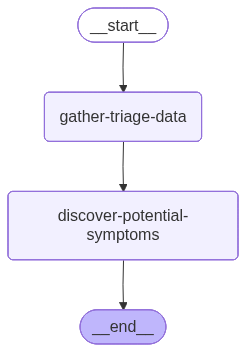

In [16]:
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display

# Build the graph
builder = StateGraph(TrialAgentState)

# Add nodes
builder.add_node("gather-triage-data", get_triage_data)
builder.add_node("discover-potential-symptoms", discover_potential_symptoms)

# Add edges
builder.add_edge(START,"gather-triage-data")
builder.add_edge("gather-triage-data", "discover-potential-symptoms")
builder.add_edge("discover-potential-symptoms", END)

triage_agent = builder.compile()

display(Image(triage_agent.get_graph(xray=True).draw_mermaid_png()))

In [17]:
import time

def run_triage_agent(graph, app_summary:str, target_namespace: str, trace_service_starting_point: str, trace_name: str | None = None):
    """Test the structured graph with SREAgentState"""
    # Create initial state with SREAgentState structure
    initial_state = {
        "app_summary" : app_summary,
        "target_namespace": target_namespace,
        "trace_service_starting_point": trace_service_starting_point,
        "problematic_pods": {},
        "problematic_traces": {},
        "slow_traces": {},
        "problematic_metrics": {},
        "potential_symptoms": []
    }
    
    # Start time tracking
    start_time = time.time()

    # Configuration for the graph execution
    config = {"recursion_limit": 50}
    if trace_name:
        config["run_name"] = trace_name # type: ignore
    
    # Invoke the graph
    symptoms = graph.invoke(initial_state, config)

    # Calculate execution time
    execution_time = time.time() - start_time

    return symptoms, execution_time

In [18]:
experiment_name = input("Enter experiment name: ")

if experiment_name.strip() == "":
    experiment_name = "Triage agent"

In [19]:
app_summary = """
    The application implements a hotel reservation service, build with Go and gRPC. The initial project is extended in several ways, including adding back-end in-memory and persistent databases, adding a recommender system for obtaining hotel recommendations, and adding the functionality to place a hotel reservation. 
"""
target_namespace = "test-hotel-reservation"
service_starting_point = "frontend"

In [20]:
final_state, execTime = run_triage_agent(
    graph=triage_agent,
    app_summary=app_summary,
    target_namespace=target_namespace,
    trace_service_starting_point=service_starting_point,
    trace_name=experiment_name
)

In [21]:
potential_symptoms = final_state["potential_symptoms"].symptoms

for i, symptom in enumerate(potential_symptoms):
    print(f"\n ### Symptom {i+1} ###\nPotential symptom: {symptom.potential_symptom}\nAffected pod: {symptom.affected_pod}\nEvidence: {symptom.evidence}\n")



 ### Symptom 1 ###
Potential symptom: Container CrashLoopBackOff (pod repeatedly failing to start)
Affected pod: geo-6b4b89b5f5-2fltz
Evidence: problematic_pods -> pod_name=geo-6b4b89b5f5-2fltz, container_name=hotel-reserv-geo, issue_type=Waiting, reason=CrashLoopBackOff, message='back-off 5m0s restarting failed container=hotel-reserv-geo ...', restart_count=8


 ### Symptom 2 ###
Potential symptom: Pod instability / frequent restarts
Affected pod: geo-6b4b89b5f5-2fltz
Evidence: problematic_pods shows restart_count=8 for container hotel-reserv-geo and CrashLoopBackOff back-off message indicating repeated failures and restart cycling


 ### Symptom 3 ###
Potential symptom: Frontend RPC calls to 'search' failing with 'Unavailable' (connection pool / backend unreachability)
Affected pod: frontend (service pods)
Evidence: Error Traces: 20 traces from service='frontend' with sequence='frontend -> search' and error_message repeatedly: 'rpc error: code = Unavailable desc = there is no connec